In [174]:
from IPython.display import display, HTML
import re
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [175]:
def insert_location(conn,values):
    sql = """ INSERT INTO ProjectLocation VALUES(?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

def insert_project_details(conn,values):
    sql = """ INSERT INTO ProjectDetails VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?) """
    cur = conn.cursor()
    cur.executemany(sql,values)
    return cur.lastrowid

In [176]:
# Delete old database file
normalized_database_filename = 'normalized.db'
conn = create_connection(normalized_database_filename, delete_db=True)

In [177]:
def cleanse(city):
    digit_checker = any(chr.isdigit() for chr in city)
    
    city = city.lower()
    
    if city.endswith(','):
        city = city.replace(',','')
    
    if city.endswith(' '):
        city = city.replace(' ','')
        
    if ',' in city:
        city_modified = re.search("^([a-z]*).*$",city)
        city_modified = str(city_modified.group(1))
        city = city.replace(city,city_modified)
    
    if digit_checker == True:
        city = ''
        
    if city == "Bardinia":
        city = city.replace('Bardinia','Bardonia')
        
    if city == 'cabria hgts':
        city = city.replace('cabria hgts','cambria heights')
        
    if city == 'jackson hgts ny':
        city = city.replace('jackson hgts ny','jackson heights')
        
    if ' hts' in city:
        city = city.replace(' hts',' heights')
        
    if ' hgts' in city:
        city = city.replace(' hgts',' heights')
    
    return city.title()

In [178]:
import csv

def asSolarInfo(row):
    solar_details_dict = {'reporting_period':row[0],'project_id':row[1],'city':row[3],
                     'county':row[4],'state':row[5],'zip_code':row[6],'sector':row[7],'program_type':row[8],
                     'solicitation':row[9],'electric_utility':row[10],'purchase_type':row[11],
                     'date_application_recieved':row[12],'date_completed':row[13],
                     'project_status':row[14],'contractor':row[15],
                     'primary_inverter_manufacturer':row[16],
                     'primary_inverter_model_number':row[17],'total_inverter_quantity':row[18],
                     'primary_pv_module_manufacturer':row[19],
                     'pv_module_model_number':row[20],'total_pv_module_quantity':row[21],
                     'project_cost':row[22],'incentive':row[23],'total_nameplate_kw_dc':row[24],
                     'expected_kwh_annual_production':row[25],'remote_net_metering':row[26],
                     'affordable_solar':row[27],'community_distributed_generation':row[28],
                     'green_jobs_green_ny_participants':row[29],'loc_coordinates':row[30]}
    
    return solar_details_dict

def project_location_table(data_filename, normalized_database_filename):
    first = True
    city_list = []
    county_list = []
    state_list = []
    zip_code_list = []
    with open(data_filename) as file:
        file_reader = csv.reader(file, delimiter=',')
        for row in file_reader:
            if first:
                    first = False
                    continue
            info = asSolarInfo(row)
            city = cleanse(info['city'])
            if not city in city_list:
                city_list.append(city)
                county_list.append(info['county'])
                state_list.append(info['state'])
                zip_code_list.append(info['zip_code'])

    location_details = zip(city_list,county_list,state_list,zip_code_list)
    
                
    project_location_table = """create table ProjectLocation
    ([City] TEXT PRIMARY KEY,
    [County] TEXT,
    [State] TEXT,
    [ZipCode] TEXT
    );"""
    create_table(conn, project_location_table,True)
    insert_location(conn,location_details)
    conn.commit()
                

In [179]:
data_filename = '/Users/raj/Desktop/Project/solar.csv'
normalized_database_filename = 'normalized.db'
project_location_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectLocation""", conn)
print(df)

                  City    County State ZipCode
0              Medford   Suffolk    NY   11763
1            Calverton   Suffolk    NY   11933
2            Hauppauge   Suffolk    NY   11788
3     Saratoga Springs  Saratoga    NY   12866
4          Trumansburg  Tompkins    NY   14886
...                ...       ...   ...     ...
2210      Statn Island  Richmond    NY   10301
2211             Earon   Madison    NY   13334
2212           Rosalyn    Nassau    NY   11576
2213            Benton     Yates    NY   14527
2214      Rocky Pooint   Suffolk    NY   11778

[2215 rows x 4 columns]


In [180]:
# CREATING THE NON-NORMALIZED DATABASE
import csv



def asSolarInfo(row):
    
    loc_coor = row[30]
    loc_coor_modified = re.search("[^(]*([+-]?\d+\.\d+, *[+-]?\d+.\d+)", loc_coor)
    loc_coor_modified = "(" + loc_coor_modified.group(0) + ")"
    city = cleanse(row[3])
    solar_details_dict = {'reporting_period':row[0],'project_id':row[1],'city':city,
                     'county':row[4],'state':row[5],'zip_code':row[6],'sector':row[7],'program_type':row[8],
                     'solicitation':row[9],'electric_utility':row[10],'purchase_type':row[11],
                     'date_application_recieved':row[12],'date_completed':row[13],
                     'project_status':row[14],'contractor':row[15],
                     'primary_inverter_manufacturer':row[16],
                     'primary_inverter_model_number':row[17],'total_inverter_quantity':row[18],
                     'primary_pv_module_manufacturer':row[19],
                     'pv_module_model_number':row[20],'total_pv_module_quantity':row[21],
                     'project_cost':row[22],'incentive':row[23],'total_nameplate_kw_dc':row[24],
                     'expected_kwh_annual_production':row[25],'remote_net_metering':row[26],
                     'affordable_solar':row[27],'community_distributed_generation':row[28],
                     'green_jobs_green_ny_participants':row[29],'loc_coordinates':loc_coor_modified}
    return solar_details_dict
def project_details_table(data_filename, normalized_database_filename):
    first = True
    reporting_period_list = []
    project_id_list = []
    city_list = []
    county_list = []
    state = []
    zip_code_list = []
    sector_list = []
    program_type_list = []
    solicitation_list = []
    electric_utility_list = []
    purchase_type_list = []
    date_application_recieved_list = []
    date_completed_list = []
    project_status_list = []
    contractor_list = []
    inverter_manufacturer_list = []
    inverter_model_no_list = []
    total_inverter_quantity_list = []
    pv_module_manufacturer_list = []
    pv_module_model_number_list = []
    total_pv_module_quantity_list = []
    project_cost_list = []
    incentive_list = []
    total_nameplate_kw_dc_list = []
    expected_kwh_annual_production_list = []
    remote_net_metering_list = []
    affordable_solar_list = []
    community_distributed_generation_list = []
    green_jobs_green_ny_participants_list = []
    loc_coordinates_list = []
    with open(data_filename) as file:
        file_reader = csv.reader(file, delimiter=',')
        for row in file_reader:
            if first:
                    first = False
                    continue
            info = asSolarInfo(row)
            reporting_period_list.append(info['reporting_period'])
            project_id_list.append(info['project_id'])
            city_list.append(info['city'])
            county_list.append(info['county'])
            state.append(info['state'])
            zip_code_list.append(info['zip_code'])
            sector_list.append(info['sector'])
            program_type_list.append(info['program_type'])
            solicitation_list.append(info['solicitation'])
            electric_utility_list.append(info['electric_utility'])
            purchase_type_list.append(info['purchase_type'])
            date_application_recieved_list.append(info['date_application_recieved'])
            date_completed_list.append(info['date_completed'])
            project_status_list.append(info['project_status'])
            contractor_list.append(info['contractor'])
            inverter_manufacturer_list.append(info['primary_inverter_manufacturer'])
            inverter_model_no_list.append(info['primary_inverter_model_number'])
            total_inverter_quantity_list.append(info['total_inverter_quantity'])
            pv_module_manufacturer_list.append(info['primary_pv_module_manufacturer'])
            pv_module_model_number_list.append(info['pv_module_model_number'])
            total_pv_module_quantity_list.append(info['total_pv_module_quantity'])
            project_cost_list.append(info['project_cost'])
            incentive_list.append(info['incentive'])
            total_nameplate_kw_dc_list.append(info['total_nameplate_kw_dc'])
            expected_kwh_annual_production_list.append(info['expected_kwh_annual_production'])
            remote_net_metering_list.append(info['remote_net_metering'])
            affordable_solar_list.append(info['affordable_solar'])
            community_distributed_generation_list.append(info['community_distributed_generation'])
            green_jobs_green_ny_participants_list.append(info['green_jobs_green_ny_participants'])
            loc_coordinates_list.append(info['loc_coordinates'])
        
    solar_project_details = zip(reporting_period_list,project_id_list,city_list,county_list,
                                state,zip_code_list,sector_list,program_type_list,
                                solicitation_list,electric_utility_list,purchase_type_list,
                                date_application_recieved_list,date_completed_list,
                                project_status_list,contractor_list,
                                inverter_manufacturer_list,inverter_model_no_list,
                                total_inverter_quantity_list,pv_module_manufacturer_list,
                                pv_module_model_number_list,total_pv_module_quantity_list,
                                project_cost_list,incentive_list,total_nameplate_kw_dc_list,
                                expected_kwh_annual_production_list,remote_net_metering_list,
                                affordable_solar_list,community_distributed_generation_list,
                                green_jobs_green_ny_participants_list,loc_coordinates_list)
        
    project_details_table = """CREATE TABLE ProjectDetails
    ([ReportingPeriod] TEXT,
    [ProjectID] TEXT PRIMARY KEY, 
    [City] TEXT,
    [County] TEXT,
    [State] TEXT,
    [ZipCode] TEXT,
    [Sector] TEXT,
    [ProgramType] TEXT,
    [Solicitation] TEXT,
    [ElectricUtility] TEXT,
    [PurchaseType] TEXT,
    [DateRecieved] TEXT,
    [DateCompleted] TEXT,
    [ProjectStatus] TEXT,
    [Contractor] TEXT,
    [InverterManufacturer] TEXT,
    [InverterModelNumber] TEXT,
    [TotalInverterQuantity] TEXT,
    [PvModuleManufacturer] TEXT,
    [PvModuleModelNumber] TEXT,
    [TotalPvModuleQuantity] TEXT,
    [ProjectCost] TEXT,
    [Incentive] TEXT,
    [TotalNameplateKwDc] TEXT,
    [ExpectedKwhAnnualProduction] TEXT,
    [RemoteNetMetering] TEXT,
    [AffordableSolar] TEXT,
    [CommunityDistrbutedGeneration] TEXT,
    [GreenJobsParticipants] TEXT,
    [LocCoordinates] TEXT
    );"""
    create_table(conn, project_details_table,True)
    insert_project_details(conn,solar_project_details)
    conn.commit()
    

       ReportingPeriod         ProjectID              City       County State  \
0           10/31/2020  2011-189637-SLPR           Medford      Suffolk    NY   
1           10/31/2020  2013-530718-Sola         Calverton      Suffolk    NY   
2           10/31/2020  2014-646148-Sola         Hauppauge      Suffolk    NY   
3           10/31/2020           31307-1  Saratoga Springs     Saratoga    NY   
4           10/31/2020               431       Trumansburg     Tompkins    NY   
...                ...               ...               ...          ...   ...   
112597      10/31/2020            223126           Batavia      Genesee    NY   
112598      10/31/2020            255699          Brooklyn        Kings    NY   
112599      10/31/2020            255520         Rochester       Monroe    NY   
112600      10/31/2020            232341         Hawthorne  Westchester    NY   
112601      10/31/2020            249312           Grafton   Rensselaer    NY   

       ZipCode           Se

Text(0.5, 1.0, 'SOLAR ELECTRIC PROGRAMS')

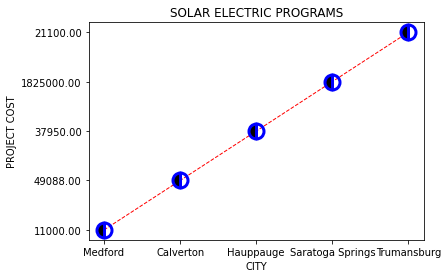

In [181]:
data_filename = '/Users/raj/Desktop/Project/solar.csv'
normalized_database_filename = 'normalized.db'
project_details_table(data_filename, normalized_database_filename)
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
df = pd.read_sql_query("""SELECT * FROM ProjectDetails""", conn)
print(df)